In [1]:
import datetime
now = datetime.datetime.now()

# Classifier

## Summer School JGU Mainz — Advanced Methods in Behavioral Economics, 2021

### Carina I. Hausladen

In [2]:
print(now.strftime("%Y-%m-%d"))

2021-09-25


Large parts of the following code are based on 
[Anirudh Shenoy](https://towardsdatascience.com/text-classification-with-extremely-small-datasets-333d322caee2)'s tutorial.
Pretrained embeddings are obtained from [deepset](https://deepset.ai/german-word-embeddings).

- In this notebook, we will learn about different algorithms that can be used for classification tasks.
- We will encounter stand-alone classifiers and ensemble methods.

In [3]:
import pickle
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler

try:
    from pymagnitude import Magnitude
except ModuleNotFoundError:  # workaround for weird bug
    from pymagnitude import Magnitude

from sklearn.feature_extraction.text import TfidfVectorizer

from utils.setup import prepare_docs
from utils.strt_grp_sffl_splt import str_grp_splt
from utils.utility import print_model_metrics, run_grid_search, fit_n_times, tfdf_embdngs

In [4]:
df = pd.read_csv('data/chat_hours_simulated.csv')  
df_new, all_docs = prepare_docs(df, y="honestmean", X="Chat_subject", dv="player.hours_stated")
all_docs.new_docs = [x if len(x) != 0 else "kein_chat" for x in all_docs.new_docs]
ros = RandomOverSampler(random_state=42, sampling_strategy='minority')

# Embeddings 
- To compare the preformance of various classifiers, we will work with one type of embeddings.
- We will use pretrained, tf-idf weighted Word2Vec embeddings.

In [5]:
tfidf = TfidfVectorizer(input='content', lowercase=False, preprocessor=lambda x: x)
w2v = Magnitude('data/w2v_vec.magnitude')
tfidf.fit(all_docs.new_docs)
idf_dict = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
X_tfidf_w2v_pre = tfdf_embdngs(all_docs.new_docs, w2v, dict_tf=idf_dict)

train_idx, test_idx = str_grp_splt(df_new,
                                   grp_col_name="group",
                                   y_col_name="honestmean",
                                   train_share=0.8)
train_X = X_tfidf_w2v_pre[train_idx]
test_X = X_tfidf_w2v_pre[test_idx]
train_y = df_new["honestmean"][train_idx]
test_y = df_new["honestmean"][test_idx]

train_X, train_y = ros.fit_resample(train_X, train_y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 351/351 [00:12<00:00, 28.68it/s]


# Cross-validation
[scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

- Learning the parameters of a prediction function and testing it on the same data is a methodological mistake.
- The model would have a perfect score but it would fail to predict on unseen data (overfitting!). 
- To avoid it, it is common practice to hold out part of the available data as a test set.  

- When evaluating hyperparameters for estimators, we risk to overfit on the test set.
- To solve this problem, we partition the data into three sets:
    - Training proceeds on the training set.
    - Evaluation is done on the validation set.
    - Final evaluation can be done on the test set.

- Problem: 
    - We drastically reduce the number of samples which can be used for learning the model. 
    - The results can depend on a particular random choice for the splits.

- Solution: cross-validation 
    - A test set is held out for final evaluation.
    - k-fold CV: the training set is split into `k` smaller set.
    - If `k=5`, the dataset will be divided into 5 equal parts and the below process will run 5 times, each time with a different holdout set.

```
                    TRAINING DATA
iteration 1 | TEST  | train | train | train | train
iteration 2 | train | TEST  | train | train | train
iteration 3 | train | train | TEST  | train | train
iteration 4 | train | train | train | TEST  | train
iteration 5 | train | train | train | train | TEST
                                                    TEST DATA
```

# Tuning Hyperparameters
[scikit-learn](https://scikit-learn.org/stable/modules/grid_search.html#grid-search), [Rahil Shaikh](https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85)

* Hyperparameters are not directly learnt within estimators. 
* Typical examples include `C`, `kernel` and `gamma` , etc.
* It is recommended to search the hyperparameter space for the best cross validation score.

We deploy an exhaustive Grid Search via [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). It searches over a specified parameter grid. 

```python
def run_grid_search(model, params, x_train, y_train):
    grid = GridSearchCV(model, params, cv=5, n_jobs=-1, 
                        scoring=score, verbose=0, refit=False)
    grid.fit(x_train, y_train)
    return (grid.best_params_, grid.best_score_)
```

# Classifier

## Logistic Regression
[scikit-learn](https://scikit-learn.org/stable/modules/sgd.html#sgd)<br>

* Stochastic Gradient Descent (SGD) is an approach to fitting linear classifiers under convex loss functions such as Logistic Regression. 
* SGD has been successfully applied to large-scale and sparse machine learning problems often encountered in text classification and natural language processing. 
* SGD is an optimization technique, in other words, it is a way to train a model. 
* `SGDClassifier(loss='log')` results in logistic regression.

In [6]:
from sklearn.linear_model import SGDClassifier

lr = SGDClassifier(loss='log')
lr_params = {'alpha': [10 ** (-x) for x in range(7)],
             'penalty': ['l1', 'l2', 'elasticnet'],
             'l1_ratio': [0.15, 0.25, 0.5, 0.75]}
best_params, best_f1 = run_grid_search(lr, lr_params, train_X, train_y)

print('Best Parameters : {}'.format(best_params))
print('Best F1 : {}'.format(best_f1))

lr = SGDClassifier(loss='log',
                   alpha=best_params['alpha'],
                   penalty=best_params['penalty'],
                   l1_ratio=best_params['l1_ratio'])
metrics_lr = fit_n_times(lr, train_X, train_y, test_X, test_y)

Best Parameters : {'alpha': 1e-06, 'l1_ratio': 0.75, 'penalty': 'l1'}
Best F1 : 0.6794491036879097
F1: 0.803 | Pr: 0.683 | Re: 0.997 | AUC: 0.525 | Accuracy: 0.677 



## SVM
[scikit-learn](https://scikit-learn.org/stable/modules/svm.html#classification)<br>
We already know how support vector machines work :)!

In [7]:
from sklearn.svm import SVC

svm = SVC(probability=True)
svm_params = {'C': [10 ** (x) for x in range(-1, 4)],
              'kernel': ['poly', 'rbf', 'linear'],
              'degree': [2, 3]}

best_params, best_f1 = run_grid_search(svm, svm_params, train_X, train_y)

print('Best Parameters : {}'.format(best_params))
print('Best F1 : {}'.format(best_f1))

svm = SVC(C=best_params['C'], kernel=best_params['kernel'], degree=best_params['degree'], probability=True)
metrics_svm = fit_n_times(svm, train_X, train_y, test_X, test_y)

Best Parameters : {'C': 100, 'degree': 2, 'kernel': 'linear'}
Best F1 : 0.6767073722297603
F1: 0.795 | Pr: 0.670 | Re: 1.000 | AUC: 0.502 | Accuracy: 0.660 



 ## KNN
[Nearest Neighbors Classification¶](https://scikit-learn.org/stable/modules/neighbors.html#classification)

* Neighbors-based classification is a type of instance-based learning or non-generalizing learning: 
    * It does not construct a general internal model. 
    * Instead, it stores instances of the training data. 

* Classification: A point is assigned to the data class which has the most representatives within the nearest neighbors of the point.

* The optimal choice of the value $k$ is data-dependent: 
    * A larger $k$ suppresses the effects of noise.
    * It makes the classification boundaries less distinct.

* Weights
    * `weights = 'uniform'`: The value assigned to a query point is computed from a majority vote of the nearest neighbors. 
    * `weights = 'distance'`: Weights are assigned proportionally to the inverse of the distance from the query point; Nearer neighbors contribute more to the fit.

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs=-1)
knn_params = {'n_neighbors': [3, 5, 7, 9, 15, 31],
              'weights': ['uniform', 'distance']
              }

best_params, best_f1 = run_grid_search(knn, knn_params, train_X, train_y)
print('Best Parameters : {}'.format(best_params))

knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'], n_jobs=-1)

metrics_knn = fit_n_times(knn, train_X, train_y, test_X, test_y)

Best Parameters : {'n_neighbors': 5, 'weights': 'distance'}
F1: 0.800 | Pr: 0.670 | Re: 1.000 | AUC: 0.495 | Accuracy: 0.670 



## Multi-Layer Perceptron
- A multi-layer perceptron (MLP) is a simple feedforward neural network. 
- It consists of an 
    - input layer that represents an encoding of our text input; 
    - an arbitrary number (in our case one) of hidden layers; 
    - and an output layer that represents the predicted class.

<img src="figures/mlp.png" alt="mlp" width="400"/>

### How does a neuron work?

- The terms "dense" and "feedforward" mean that all outputs of a layer are inputs for each neuron in the susequent layer. 
- The output of a single neuron can be formulated as follows:
    - **x** are the inputs 
    - **w** are trainable weights
    - **y** is the output
    - **b** is a constant bias
    - **f<sub>A</sub>** is a non-linear activation function

<img src="figures/neuron_formula.png" alt="neuron formula" width="200"/>
<img src="figures/neuron.png" alt="neuron" width="400"/>

### Activation functions

- In order to create a non-linear model, a MLP must not consist of linear activation functions only. 
- The choice of the right activation function is a much discussed topic in machine learning research and depends on the task to solve (regression or classification) and on whether it is applied to a hidden or the output layer. 
- These are some of the most common activation functions

<img src="figures/activation_functions.png" alt="activation functions" width="500"/>

### Learning through back-propagation

- "Back-propagation" is an algorithm to calculate the gradient for each weight in the neural network.
- It estimates the contribution to the error (loss) of each weight starting from the output layer.
- The gradient is then used by an optimization algorithm (usually stochastic gradient descent based methods) to update the model weights.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 128
epochs = 10

simple_nn = Sequential()
simple_nn.add(Dense(300, activation='relu', input_shape=(300,)))  # input layer
simple_nn.add(Dropout(0.2))
simple_nn.add(Dense(200, activation='relu')) # hidden layer
simple_nn.add(Dropout(0.2))
simple_nn.add(Dense(1, activation='sigmoid')) # output layer
simple_nn.summary()

simple_nn.compile(loss='binary_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

checkpoint = ModelCheckpoint('data/interim/saved_models', monitor='val_accuracy', verbose=1, save_best_only=True)
history = simple_nn.fit(train_X, train_y.values,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        callbacks=[checkpoint],
                        validation_data=(test_X, test_y.values))
y_pred_prob = simple_nn.predict(test_X)  # eliminated all .todense() --> no longer necessary when w2v instead of tfidf
metrics_nn = print_model_metrics(test_y, y_pred_prob, return_metrics=True)

2021-09-25 14:33:18.006139: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-25 14:33:18.072802: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               90300     
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 150,701
Trainable params: 150,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3/3 [==============================] - 1s 67ms/step - loss: 0.6934 - accuracy: 0.5115 - val_loss: 0.6800 

2021-09-25 14:33:18.860012: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/interim/saved_models/assets
Epoch 2/10
3/3 [==============================] - 0s 11ms/step - loss: 0.6949 - accuracy: 0.5000 - val_loss: 0.6726 - val_accuracy: 0.6702

Epoch 00002: val_accuracy did not improve from 0.69149
Epoch 3/10
3/3 [==============================] - 0s 12ms/step - loss: 0.6914 - accuracy: 0.5115 - val_loss: 0.6839 - val_accuracy: 0.6809

Epoch 00003: val_accuracy did not improve from 0.69149
Epoch 4/10
3/3 [==============================] - 0s 11ms/step - loss: 0.6899 - accuracy: 0.5458 - val_loss: 0.6983 - val_accuracy: 0.3191

Epoch 00004: val_accuracy did not improve from 0.69149
Epoch 5/10
3/3 [==============================] - 0s 11ms/step - loss: 0.6893 - accuracy: 0.5305 - val_loss: 0.7094 - val_accuracy: 0.3298

Epoch 00005: val_accuracy did not improve from 0.69149
Epoch 6/10
3/3 [==============================] - 0s 11ms/step - loss: 0.6904 - accuracy: 0.5076 - val_loss: 0.7221 - val_accuracy: 0.3298

Epoch 00006:

## Ensemble Methods
Ensemble methods are machine learning techniques that combine several base models in order to produce one optimal predictive model.

### Random Forest
[scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [Skyler Dale](https://towardsdatascience.com/an-intuitive-explanation-of-random-forests-109b04bca343) <br>

* A random forest is a meta estimator that fits a number of decision tree classifiers.
* Each decision tree is trained on a different subset of the data.
* A random subset of the full list of features is selected at every split in each decision tree. 
* The resulting trees have been exposed to different information.
* For a regression problem, the random forest takes the average of each tree's prediction. 
* For classification, it takes the mode or majority.
* The goal is to improve the predictive accuracy and control over-fitting. 

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1)

rf_params = {'n_estimators': [10, 100, 250, 500, 1000],
             'max_depth': [None, 3, 7, 15],
             'min_samples_split': [2, 5, 15]
             }

best_params, best_f1 = run_grid_search(rf, rf_params, train_X, train_y)

print('Best Parameters : {}'.format(best_params))
rf = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                            min_samples_split=best_params['min_samples_split'],
                            max_depth=best_params['max_depth'],
                            n_jobs=-1)
metrics_rf = fit_n_times(rf, train_X, train_y, test_X, test_y)

Best Parameters : {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 250}
F1: 0.806 | Pr: 0.686 | Re: 1.000 | AUC: 0.534 | Accuracy: 0.682 



### Bagging
[scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html), [Breimann (1996)](https://link.springer.com/article/10.1007/BF00058655) <br>

* Bagging stands for bootstrap and aggregation.
* A bagging classifier fits base classifiers each on random subsets of the original dataset.
* To form a final prediction, it aggregates their individual predictions (either by voting or by averaging). 
* The goal is to reduce the variance of a black-box estimator.
* Difference to random forests:
    * Random forests only select a subset of features at random out of the total and the best split feature from the subset is used to split each node in a tree.
    * Bagging considers all features for splitting a node.

In the following, we use svm as base estimator.

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

svm = SVC(C=10, kernel='poly', degree=2, probability=True, verbose=0)

svm_bag = BaggingClassifier(svm, n_estimators=200, max_features=0.9, max_samples=1.0, bootstrap_features=False,
                            bootstrap=True, n_jobs=1, verbose=0)

svm_bag.fit(train_X, train_y)
y_test_prob = svm_bag.predict_proba(test_X)[:, 1]
metrics_bag_svm = print_model_metrics(test_y, y_test_prob, return_metrics=True)

F1: 0.795 | Pr: 0.670 | Re: 1.000 | AUC: 0.520 | Accuracy: 0.660 



### Stacked Generalization
[scikit-learn](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization), [Wolpert (1992)](https://www.sciencedirect.com/science/article/pii/S0893608005800231)

* Model stacking is a method for combining estimators to reduce their biases.
* The predictions of each individual estimator are stacked together and used as input to a final estimator to compute the prediction. 
* This final estimator is trained through cross-validation.

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


class StackingClassifier:

    def __init__(self):
        lr = SGDClassifier(loss='log', alpha=0.1, penalty='elasticnet')
        svm = SVC(C=10, kernel='poly', degree=2, probability=True)
        nb = MultinomialNB(alpha=10000, class_prior=[0.5, 0.5])
        knn = KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=-1)
        rf = RandomForestClassifier(n_estimators=50, min_samples_split=5, max_depth=15,
                                    n_jobs=-1)  # n_estimators=250 runs for a long time

        self.model_dict = dict(zip(['LR', 'SVM', 'KNN', 'RF'], [lr, svm, knn, rf]))
        self.model_weights = {'LR': 0.9,
                              'SVM': 0.9,
                              #  'NB': 0.8,
                              'KNN': 0.75,
                              'RF': 0.75,
                              #'XGB': 0.6,
                              'simple_nn': 0.7
                              }

    def fit(self, X, y):
        for model_name, model in self.model_dict.items():
            print('Training {}'.format(model_name))
            model.fit(X, y)

    def predict_proba(self, X):
        global simple_nn
        y_pred_prob = 0

        for model_name, model in self.model_dict.items():
            y_pred_prob += (model.predict_proba(X)[:, 1] * self.model_weights[model_name])

        y_pred_prob += (simple_nn.predict(X).ravel() * self.model_weights['simple_nn'])
        y_pred_prob /= sum(self.model_weights.values())
        return y_pred_prob

    def optimize_weights(self, X, y):

        def _run_voting_clf(model_weights):
            global simple_nn
            y_pred_prob = 0
            for model_name, model in self.model_dict.items():
                y_pred_prob += (model.predict_proba(X)[:, 1] * model_weights[model_name])
            y_pred_prob += (simple_nn.predict(X).ravel() * model_weights['simple_nn'])
            y_pred_prob /= sum(model_weights.values())
            f1 = print_model_metrics(y, y_pred_prob, return_metrics=True, verbose=0)[0]
            return {'loss': -f1, 'status': STATUS_OK}

        trials = Trials()
        self.model_weights = fmin(_run_voting_clf,
                                  space={
                                      'LR': hp.uniform('LR', 0, 1),
                                      'SVM': hp.uniform('SVM', 0, 1),
                                      #    'NB': hp.uniform('NB', 0, 1),
                                      'KNN': hp.uniform('KNN', 0, 1),
                                      'RF': hp.uniform('RF', 0, 1),
                                      # 'XGB': hp.uniform('XGB', 0, 1),
                                      'simple_nn': hp.uniform('simple_nn', 0, 1),
                                  },
                                  algo=tpe.suggest,
                                  max_evals=500,
                                  trials=trials)

Training LR
Training SVM
Training KNN
Training RF
100%|█████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.86trial/s, best loss: -0.8104575163398694]
F1: 0.810 | Pr: 0.692 | Re: 1.000 | AUC: 0.508 | Accuracy: 0.691 



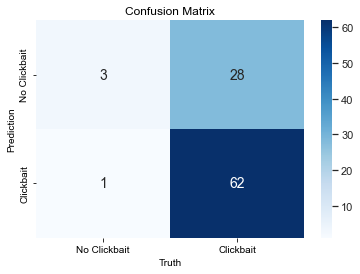

In [13]:
stacking_clf = StackingClassifier()
stacking_clf.fit(train_X, train_y)
stacking_clf.optimize_weights(test_X, test_y)
y_pred_prob = stacking_clf.predict_proba(test_X)
np.save('data/interim/stacked_prediction.npy', y_pred_prob)  # save predictions
metrics_stack = print_model_metrics(test_y, y_pred_prob, confusion=True, return_metrics=True)

filename = 'data/interim/best_model.sav'
pickle.dump(stacking_clf, open(filename, 'wb'))

In [14]:
metrics_all = pd.DataFrame(np.stack([metrics_lr,
                                     metrics_svm,
                                     metrics_knn,
                                     metrics_rf,
                                     metrics_nn,
                                     metrics_bag_svm,
                                     metrics_stack
                                     ]),
                           columns=["f1", "prec", "rec", "AUC", "acc"],
                           index=["LLR", "SVM", "KNN", "RF", 
                                  "NN", "Bagging", "Stacking"])
metrics_all.round(decimals=3).sort_values(by="f1", ascending=False)

,f1,prec,rec,AUC,acc
NN,0.813,0.705,0.984,0.537,0.702
Stacking,0.810,0.692,1.000,0.508,0.691
RF,0.806,0.686,1.000,0.534,0.682
LLR,0.803,0.683,0.997,0.525,0.677
KNN,0.800,0.670,1.000,0.495,0.670
SVM,0.795,0.670,1.000,0.502,0.660
Bagging,0.795,0.670,1.000,0.520,0.660
